<a href="https://colab.research.google.com/github/PuroshotamSingh/Speech-Emotion-Recognition/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install soundfile

In [ ]:
import soundfile
import numpy as np
import librosa
import glob
import os
from sklearn.model_selection import train_test_split

# all emotions on RAVDESS dataset
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
    }

In [ ]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [ ]:
def load_data(test_size=0.2):
  X, y = [], []
  try :
    for file in glob.glob("/content/drive/MyDrive/features/Actor_*/*.wav"):
      # get the base name of the audio file
      basename = os.path.basename(file)
      # print(basename)
      # get the emotion label
      emotion = int2emotion[basename.split("-")[2]]
      # we allow only AVAILABLE_EMOTIONS we set
      features = extract_feature(file, mfcc=True, chroma=True, mel=True)
      # add to data
      X.append(features)
      l={'happy':0.0,'sad':1.0,'neutral':3.0,'angry':4.0, 'calm':5.0, 'fearful':6.0, 'disgust':7.0, 'surprised':8.0}
      y.append(l[emotion])
  except :
    pass
    # split the data to training and testing and return it
  return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [ ]:
X_train, X_test, y_train, y_test = load_data(test_size=0.25)

print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])

[+] Number of training samples: 2309
[+] Number of testing samples: 770


In [ ]:
import numpy as np
X_train = np.asarray(X_train)
y_train= np.asarray(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((2309, 180), (2309,), (770, 180), (770,))

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape,x_testcnn.shape

((2309, 180, 1), (770, 180, 1))

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(128, 5,padding='same',input_shape=(180,1)))        #1
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))



model.add(Conv1D(128, 5,padding='same',))                           #2
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(9))                                                 #3
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 180, 128)          768       
_________________________________________________________________
activation_9 (Activation)    (None, 180, 128)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 180, 128)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 22, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 22, 128)           82048     
_________________________________________________________________
activation_10 (Activation)   (None, 22, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 22, 128)          

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=20, epochs=500, validation_data=(x_testcnn, y_test), callbacks=callbacks_list)

Epoch 1/500
116/116 [==============================] - 3s 19ms/step - loss: 2.3633 - accuracy: 0.3075 - val_loss: 1.1347 - val_accuracy: 0.6935

Epoch 00001: val_accuracy improved from -inf to 0.69351, saving model to model.h5
Epoch 2/500
116/116 [==============================] - 2s 18ms/step - loss: 1.5379 - accuracy: 0.5115 - val_loss: 0.9402 - val_accuracy: 0.7078

Epoch 00002: val_accuracy improved from 0.69351 to 0.70779, saving model to model.h5
Epoch 3/500
116/116 [==============================] - 2s 17ms/step - loss: 1.1955 - accuracy: 0.6202 - val_loss: 0.7693 - val_accuracy: 0.7818

Epoch 00003: val_accuracy improved from 0.70779 to 0.78182, saving model to model.h5
Epoch 4/500
116/116 [==============================] - 2s 17ms/step - loss: 0.9657 - accuracy: 0.6973 - val_loss: 0.6893 - val_accuracy: 0.7468

Epoch 00004: val_accuracy did not improve from 0.78182
Epoch 5/500
116/116 [==============================] - 2s 17ms/step - loss: 0.8369 - accuracy: 0.7393 - val_loss:

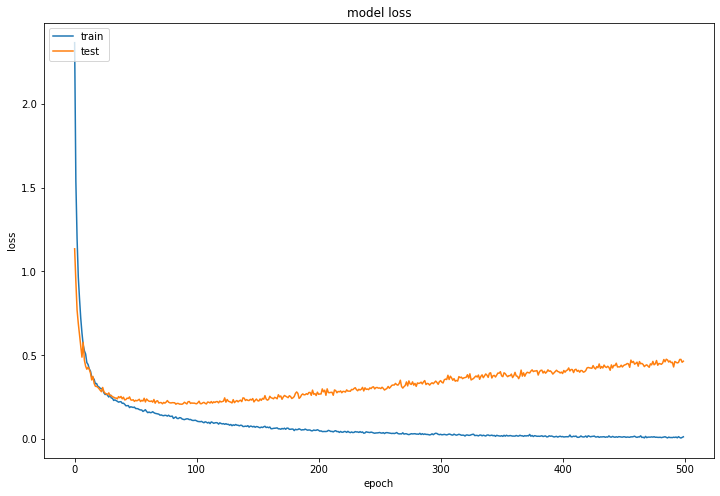

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

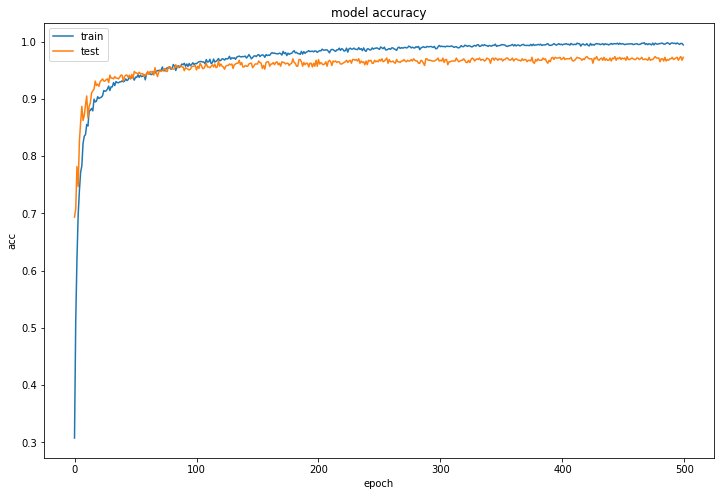

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Second**

In [ ]:
um = Sequential()

um.add(Conv1D(128, 5,padding='same',input_shape=(180,1)))#1
um.add(Activation('relu'))
um.add(Dropout(0.25))
um.add(MaxPooling1D(pool_size=(8)))

um.add(Conv1D(128, 5,padding='same',))                  #2
um.add(Activation('relu'))
um.add(MaxPooling1D(pool_size=(8)))
um.add(Dropout(0.25))

um.add(Conv1D(128, 5,padding='same',))                  #3
um.add(Activation('relu'))
um.add(Dropout(0.25))

um.add(Flatten())
um.add(Dense(9))                                        #4                      
um.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(lr=0.00005,epsilon=None,rho=0.9,decay=0.0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
um.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("model1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [ ]:
umhistory=um.fit(x_traincnn, y_train, batch_size=20, epochs=500, validation_data=(x_testcnn, y_test), callbacks=callbacks_list)

Epoch 1/500
116/116 [==============================] - 3s 21ms/step - loss: 6.0480 - accuracy: 0.1416 - val_loss: 2.1010 - val_accuracy: 0.2701

Epoch 00001: val_accuracy improved from -inf to 0.27013, saving model to model1.h5
Epoch 2/500
116/116 [==============================] - 2s 19ms/step - loss: 3.4660 - accuracy: 0.2061 - val_loss: 1.6025 - val_accuracy: 0.5662

Epoch 00002: val_accuracy improved from 0.27013 to 0.56623, saving model to model1.h5
Epoch 3/500
116/116 [==============================] - 2s 19ms/step - loss: 2.5942 - accuracy: 0.2581 - val_loss: 1.5002 - val_accuracy: 0.5013

Epoch 00003: val_accuracy did not improve from 0.56623
Epoch 4/500
116/116 [==============================] - 2s 19ms/step - loss: 2.0007 - accuracy: 0.3391 - val_loss: 1.4160 - val_accuracy: 0.5688

Epoch 00004: val_accuracy improved from 0.56623 to 0.56883, saving model to model1.h5
Epoch 5/500
116/116 [==============================] - 2s 19ms/step - loss: 1.7768 - accuracy: 0.4006 - val_lo

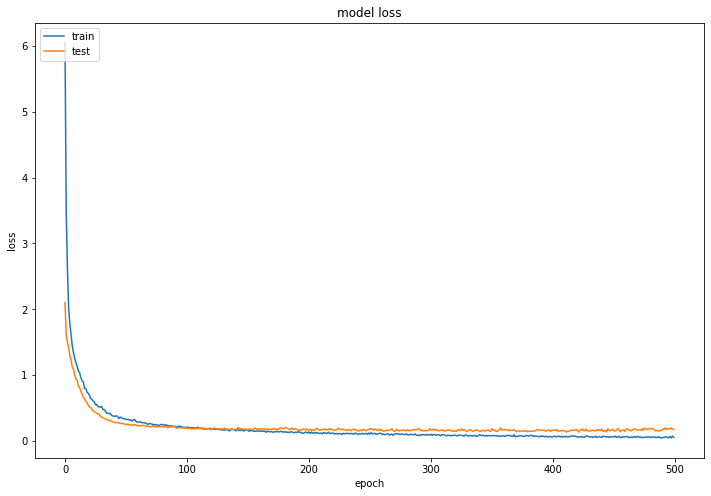

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(umhistory.history['loss'])
plt.plot(umhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

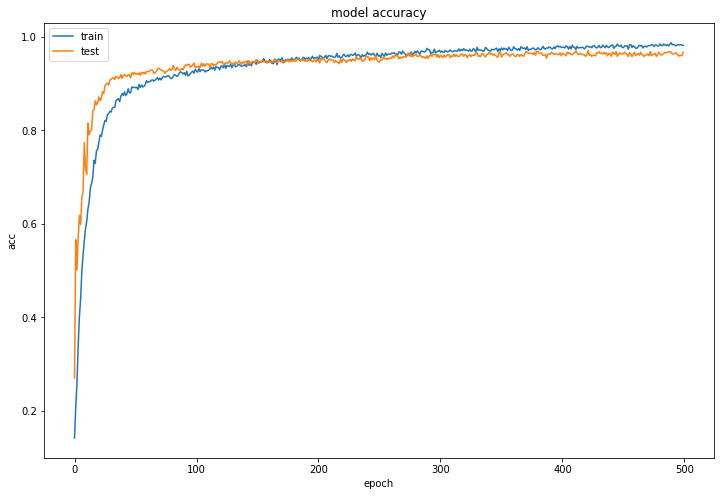

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(umhistory.history['accuracy'])
plt.plot(umhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predict_x=model.predict(x_testcnn) 
classes_x=np.argmax(predict_x,axis=1)

In [ ]:
classes_x

array([1, 6, 8, 6, 0, 6, 7, 6, 3, 6, 8, 4, 6, 8, 4, 4, 0, 3, 5, 0, 1, 8,
       1, 7, 6, 1, 8, 4, 3, 8, 6, 6, 5, 1, 4, 4, 6, 7, 8, 3, 8, 1, 0, 1,
       0, 1, 7, 3, 0, 6, 1, 0, 7, 1, 4, 4, 7, 4, 3, 7, 3, 7, 7, 3, 7, 7,
       4, 7, 1, 7, 7, 4, 7, 0, 4, 0, 0, 4, 8, 7, 3, 7, 6, 8, 4, 7, 7, 1,
       7, 3, 3, 7, 0, 6, 4, 8, 1, 7, 8, 6, 8, 8, 4, 4, 0, 0, 1, 8, 1, 3,
       3, 0, 4, 8, 3, 7, 3, 3, 4, 3, 7, 8, 8, 4, 7, 1, 7, 1, 6, 8, 6, 1,
       7, 3, 3, 6, 3, 6, 6, 6, 1, 4, 7, 6, 4, 6, 1, 1, 6, 8, 8, 7, 7, 1,
       3, 4, 1, 3, 3, 4, 0, 4, 1, 0, 3, 7, 4, 0, 1, 7, 3, 3, 7, 6, 4, 6,
       0, 6, 1, 4, 4, 6, 4, 7, 3, 6, 0, 3, 7, 8, 7, 7, 0, 7, 3, 0, 1, 0,
       1, 6, 3, 6, 7, 8, 8, 0, 3, 1, 7, 0, 3, 8, 4, 6, 0, 1, 5, 3, 6, 6,
       6, 3, 6, 6, 1, 4, 0, 7, 7, 1, 0, 6, 1, 6, 3, 3, 4, 1, 3, 1, 7, 6,
       6, 7, 7, 6, 0, 6, 0, 8, 6, 1, 3, 7, 8, 0, 6, 4, 8, 3, 6, 0, 0, 7,
       7, 6, 0, 4, 4, 0, 3, 7, 6, 1, 7, 7, 0, 5, 7, 6, 3, 0, 8, 1, 7, 1,
       7, 3, 0, 7, 6, 1, 8, 1, 0, 0, 7, 1, 8, 7, 4,

In [ ]:
y_test

array([1., 6., 8., 8., 0., 6., 7., 6., 3., 6., 8., 4., 6., 8., 4., 4., 0.,
       3., 5., 0., 1., 8., 1., 7., 6., 1., 8., 4., 3., 8., 6., 6., 5., 1.,
       4., 4., 6., 7., 8., 3., 8., 1., 0., 1., 0., 1., 7., 3., 0., 6., 1.,
       0., 7., 1., 4., 4., 7., 4., 3., 7., 3., 7., 7., 3., 7., 7., 4., 7.,
       1., 7., 7., 4., 7., 0., 4., 0., 0., 4., 8., 7., 3., 7., 6., 8., 4.,
       7., 7., 1., 7., 3., 3., 7., 0., 6., 4., 8., 1., 7., 8., 6., 8., 8.,
       4., 4., 0., 0., 1., 8., 1., 3., 3., 0., 4., 8., 3., 7., 3., 3., 4.,
       3., 7., 8., 8., 4., 7., 1., 7., 1., 6., 8., 6., 1., 7., 3., 3., 6.,
       3., 6., 6., 6., 1., 4., 7., 6., 4., 6., 1., 1., 6., 8., 8., 7., 7.,
       1., 3., 4., 1., 3., 3., 4., 0., 4., 1., 0., 3., 7., 4., 0., 1., 7.,
       3., 3., 7., 6., 4., 6., 0., 6., 1., 4., 4., 6., 4., 7., 3., 6., 0.,
       3., 7., 8., 7., 7., 0., 7., 3., 0., 1., 0., 1., 6., 3., 6., 7., 8.,
       8., 0., 3., 1., 7., 0., 3., 8., 4., 6., 0., 1., 5., 3., 6., 6., 6.,
       3., 6., 6., 1., 4.

In [ ]:
new_Ytest = y_test.astype(int)

In [ ]:
new_Ytest

array([1, 6, 8, 8, 0, 6, 7, 6, 3, 6, 8, 4, 6, 8, 4, 4, 0, 3, 5, 0, 1, 8,
       1, 7, 6, 1, 8, 4, 3, 8, 6, 6, 5, 1, 4, 4, 6, 7, 8, 3, 8, 1, 0, 1,
       0, 1, 7, 3, 0, 6, 1, 0, 7, 1, 4, 4, 7, 4, 3, 7, 3, 7, 7, 3, 7, 7,
       4, 7, 1, 7, 7, 4, 7, 0, 4, 0, 0, 4, 8, 7, 3, 7, 6, 8, 4, 7, 7, 1,
       7, 3, 3, 7, 0, 6, 4, 8, 1, 7, 8, 6, 8, 8, 4, 4, 0, 0, 1, 8, 1, 3,
       3, 0, 4, 8, 3, 7, 3, 3, 4, 3, 7, 8, 8, 4, 7, 1, 7, 1, 6, 8, 6, 1,
       7, 3, 3, 6, 3, 6, 6, 6, 1, 4, 7, 6, 4, 6, 1, 1, 6, 8, 8, 7, 7, 1,
       3, 4, 1, 3, 3, 4, 0, 4, 1, 0, 3, 7, 4, 0, 1, 7, 3, 3, 7, 6, 4, 6,
       0, 6, 1, 4, 4, 6, 4, 7, 3, 6, 0, 3, 7, 8, 7, 7, 0, 7, 3, 0, 1, 0,
       1, 6, 3, 6, 7, 8, 8, 0, 3, 1, 7, 0, 3, 8, 4, 6, 0, 1, 5, 3, 6, 6,
       6, 3, 6, 6, 1, 4, 0, 7, 7, 1, 0, 6, 1, 6, 3, 3, 4, 1, 3, 1, 7, 6,
       6, 7, 7, 6, 0, 6, 0, 8, 6, 1, 3, 7, 8, 0, 6, 4, 8, 3, 6, 0, 0, 7,
       7, 6, 0, 4, 4, 0, 3, 7, 6, 1, 7, 7, 0, 5, 7, 6, 3, 0, 8, 1, 1, 1,
       7, 3, 0, 7, 6, 1, 8, 1, 0, 0, 7, 1, 8, 7, 6,

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, classes_x)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97        97
           1       0.98      0.97      0.98       114
           3       0.99      0.97      0.98       112
           4       0.97      0.96      0.97       107
           5       0.75      1.00      0.86         9
           6       0.98      0.96      0.97       111
           7       0.95      1.00      0.98       124
           8       0.99      0.95      0.97        96

    accuracy                           0.97       770
   macro avg       0.95      0.98      0.96       770
weighted avg       0.97      0.97      0.97       770



In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, classes_x)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[ 95   0   0   0   1   1   0   0]
 [  1 111   1   0   0   0   1   0]
 [  0   1 109   0   2   0   0   0]
 [  0   0   0 103   0   0   3   1]
 [  0   0   0   0   9   0   0   0]
 [  0   1   0   2   0 107   1   0]
 [  0   0   0   0   0   0 124   0]
 [  2   0   0   1   0   1   1  91]]
